In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *



from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [2]:
# Load the California Housing dataset
housing = fetch_california_housing(as_frame=True)


df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df["target"] = housing.target

df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
df = df.reset_index(drop=True)
X = df[housing.feature_names]
targets = df["target"]
# Always use transform_data function on X
scaler = StandardScaler().fit(np.array(targets).reshape(-1, 1))
targets = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

df["target"] = targets
data=df

In [3]:
import sys
sys.path.append('..')
from xDL.models.FTTransformer import FTTransformer
from xDL.utils.data_utils import *

In [4]:
EARLY_STOPPING = EarlyStopping(
        patience=15, restore_best_weights=True, min_delta=1e-05, monitor="val_loss"
    )


In [5]:
model = FTTransformer(
        data=data, 
        y="target",
        output_activation="linear",
        binning_task="regression",
        num_encoding="one_hot_constant",
        n_bins_num=50,
        batch_size=2048,
        dropout=0.5,
        attn_dropout=0.5,
        ff_dropout=0.5,
        embedding_dim=64
        )


--- Preprocessing ---


9it [00:00, 52.24it/s]


In [6]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": "mse", "importances": None, "att_weights": None},
    metrics= {"output": "mse", "importances": None, "att_weights": None},
    )

In [7]:
model.y

'target'

In [8]:
history = model.fit(
    model.training_dataset, 
    epochs=10, 
    validation_data=model.validation_dataset,
    callbacks=[EARLY_STOPPING],
    verbose=1,
)

Epoch 1/10


8/8 [==============================] - 33s 2s/step - loss: 0.9885 - output_loss: 0.9885 - output_mse: 0.9885 - val_loss: 0.9501 - val_output_loss: 0.9501 - val_output_mse: 0.9501
Epoch 2/10
8/8 [==============================] - 17s 2s/step - loss: 0.8121 - output_loss: 0.8121 - output_mse: 0.8121 - val_loss: 0.6434 - val_output_loss: 0.6434 - val_output_mse: 0.6434
Epoch 3/10
8/8 [==============================] - 14s 2s/step - loss: 0.6271 - output_loss: 0.6271 - output_mse: 0.6271 - val_loss: 0.5090 - val_output_loss: 0.5090 - val_output_mse: 0.5090
Epoch 4/10
8/8 [==============================] - 14s 2s/step - loss: 0.5086 - output_loss: 0.5086 - output_mse: 0.5086 - val_loss: 0.3992 - val_output_loss: 0.3992 - val_output_mse: 0.3992
Epoch 5/10
8/8 [==============================] - 14s 2s/step - loss: 0.4360 - output_loss: 0.4360 - output_mse: 0.4360 - val_loss: 0.3705 - val_output_loss: 0.3705 - val_output_mse: 0.3705
Epoch 6/10
8/8 [==============================] - 14s 2s/step

In [7]:
columns_to_plot = [col for col in data.columns if col != "target"]
for col in columns_to_plot:
    print(col, next(iter(model.training_dataset))[0][col].shape)

MedInc (2048, 51)
HouseAge (2048, 51)
AveRooms (2048, 51)
AveBedrms (2048, 51)
Population (2048, 51)
AveOccup (2048, 51)
Latitude (2048, 51)
Longitude (2048, 51)


In [9]:
datasets, plotting_data = model.datamodule._generate_plotting_data_dense()
for col in columns_to_plot:
    print(col, next(iter(datasets["MedInc"]))[0][col].shape)

0it [00:00, ?it/s]

8it [00:00, 26.44it/s]

MedInc (1000, 51)
HouseAge (1000, 51)
AveRooms (1000, 51)
AveBedrms (1000, 51)
Population (1000, 51)
AveOccup (1000, 51)
Latitude (1000, 51)
Longitude (1000, 51)


In [11]:
model.training_dataset

<_PrefetchDataset element_spec=({'MedInc': TensorSpec(shape=(None, 51), dtype=tf.int64, name=None), 'HouseAge': TensorSpec(shape=(None, 51), dtype=tf.int64, name=None), 'AveRooms': TensorSpec(shape=(None, 51), dtype=tf.int64, name=None), 'AveBedrms': TensorSpec(shape=(None, 51), dtype=tf.int64, name=None), 'Population': TensorSpec(shape=(None, 51), dtype=tf.int64, name=None), 'AveOccup': TensorSpec(shape=(None, 51), dtype=tf.int64, name=None), 'Latitude': TensorSpec(shape=(None, 51), dtype=tf.int64, name=None), 'Longitude': TensorSpec(shape=(None, 51), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [14]:
next(iter(datasets["MedInc"]))[0]["Longitude"]

<tf.Tensor: shape=(1000, 51), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

8it [00:00, 81.51it/s]


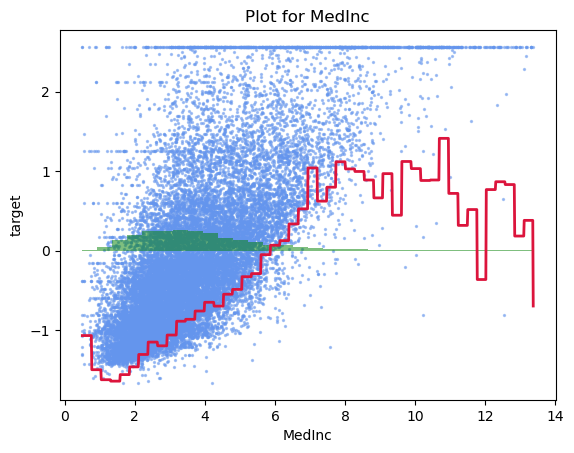

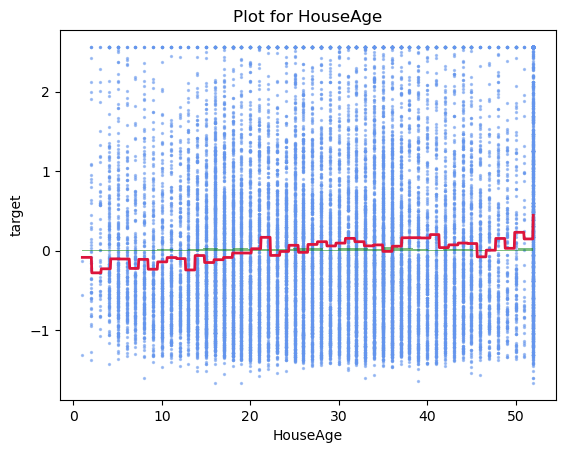

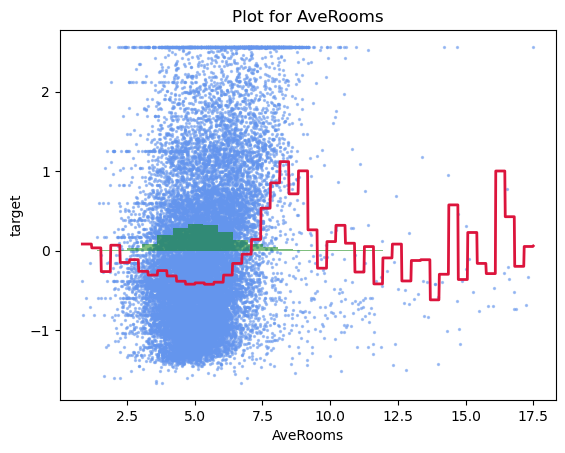

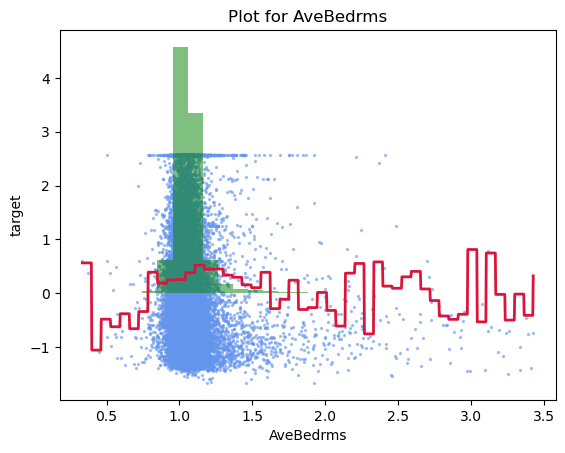

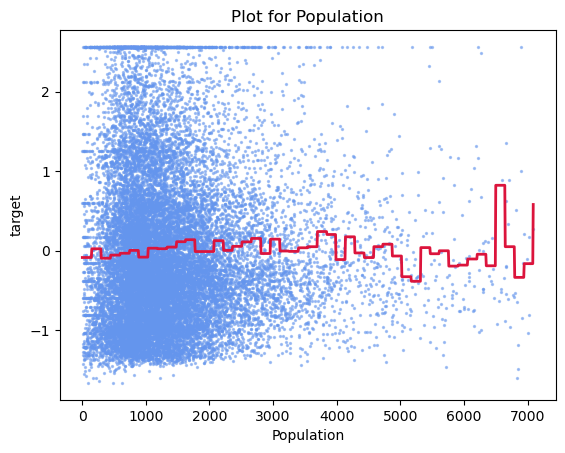

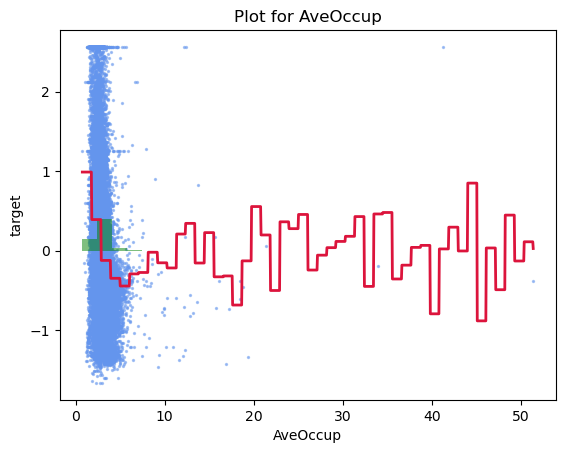

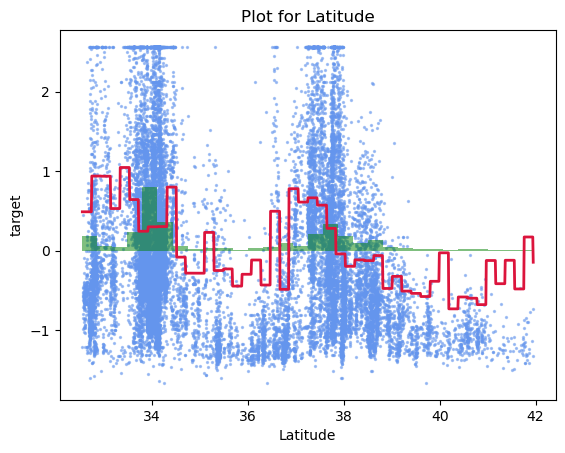

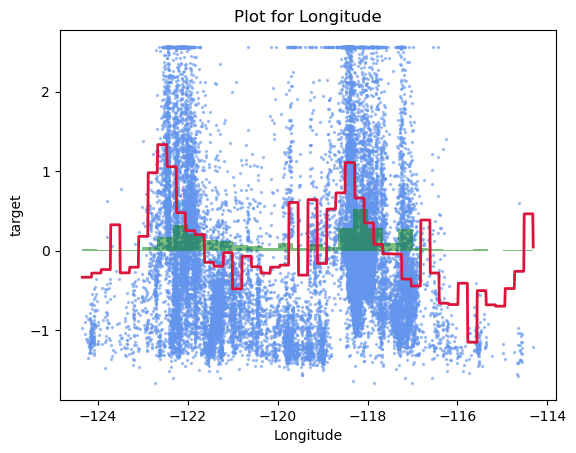

In [11]:
model.plot_features()

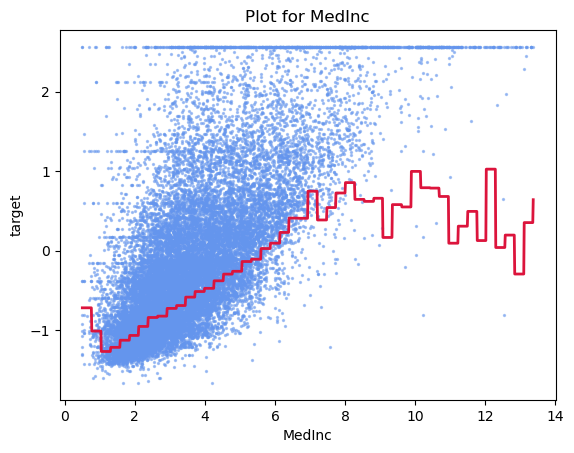

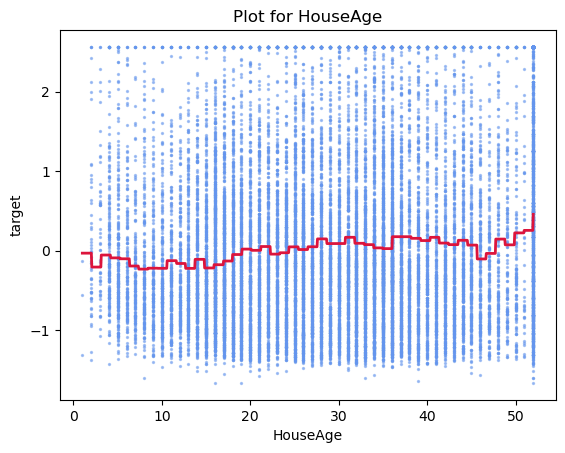

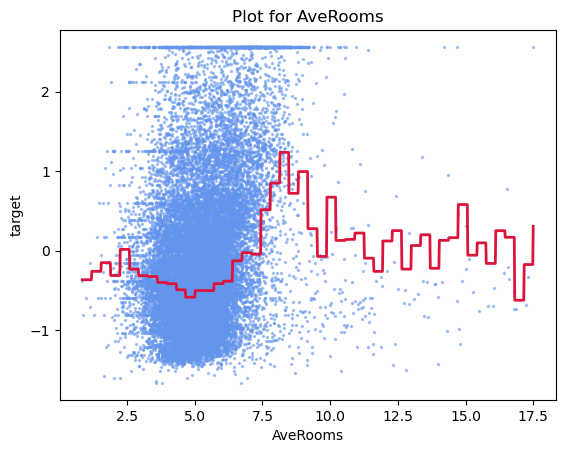

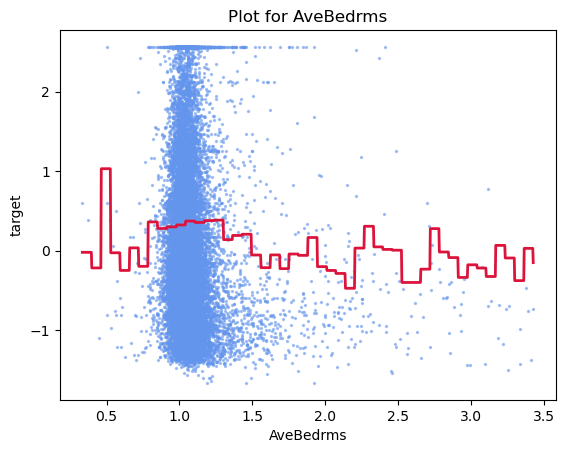

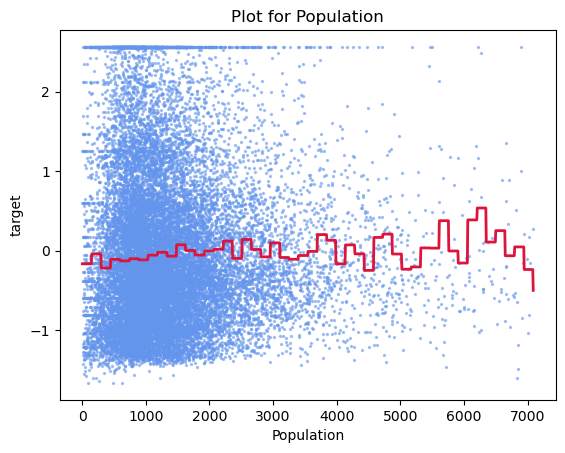

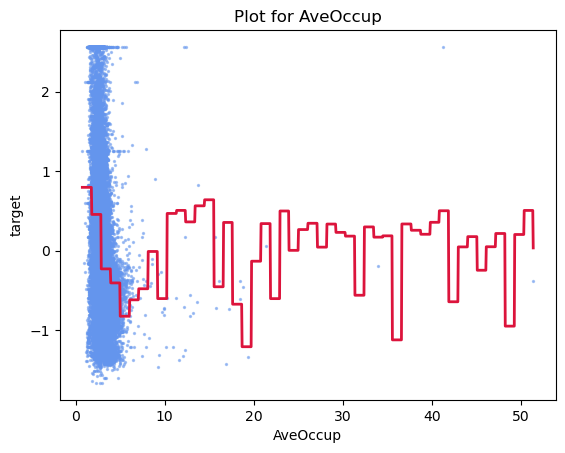

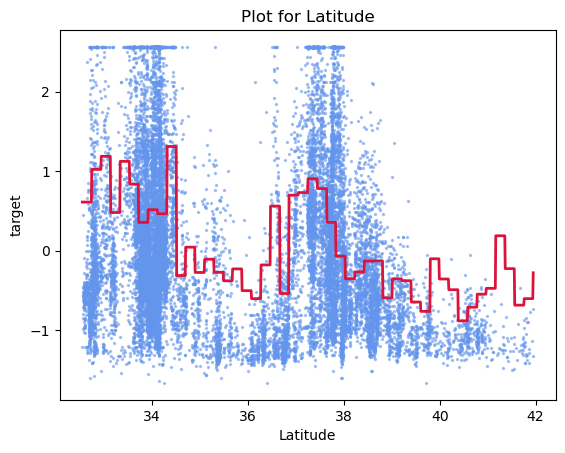

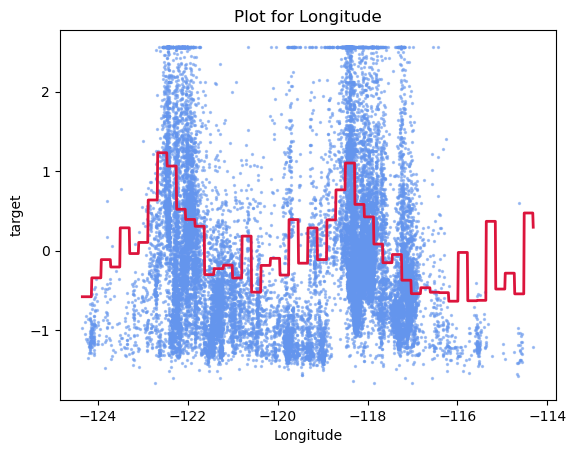

In [10]:
import matplotlib.pyplot as plt

# Get all columns except the target column
columns_to_plot = [col for col in data.columns if col != "target"]

# Create a separate plot for each column (except target) and overlay predictions
for col in columns_to_plot:
    preds = model.predict(datasets[col], verbose=0)
    preds = preds["output"].squeeze()

    fig, ax = plt.subplots()
    
    ax.scatter(data[col], data["target"], s=2, alpha=0.5, color="cornflowerblue")
    ax.plot(plotting_data[col], preds - np.mean(preds), linewidth=2, color="crimson")
    
    ax.set_title(f"Plot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("target")
    
    plt.show() 

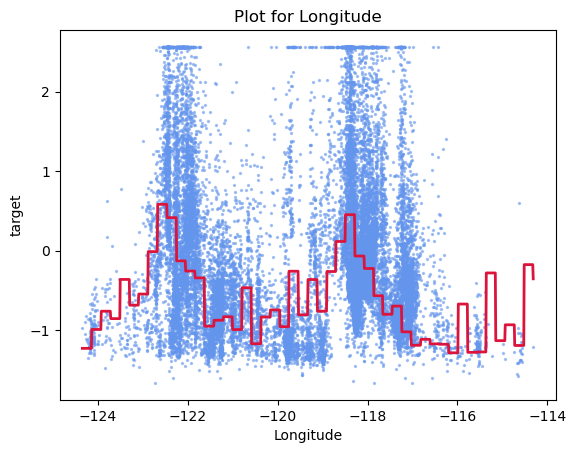

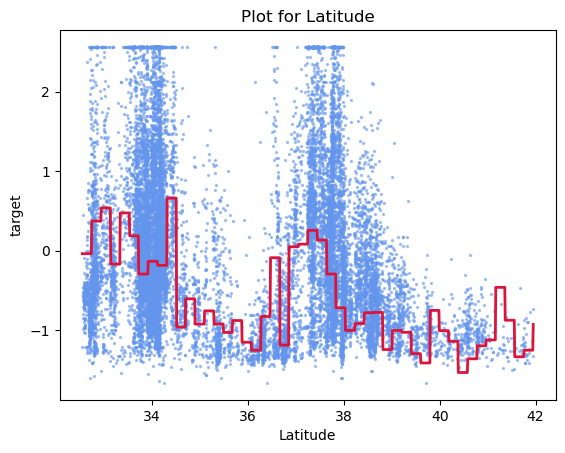

In [11]:
import matplotlib.pyplot as plt

# Get all columns except the target column
columns_to_plot = ["Longitude", "Latitude"]

# Create a separate plot for each column (except target) and overlay predictions
for col in columns_to_plot:
    preds = model.predict(datasets[col], verbose=0)
    preds = preds["output"].squeeze()

    fig, ax = plt.subplots()
    
    ax.scatter(data[col], data["target"], s=2, alpha=0.5, color="cornflowerblue")
    ax.plot(plotting_data[col], preds - np.mean(preds) - 0.65, linewidth=2, color="crimson")
    
    ax.set_title(f"Plot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("target")
    
    plt.show() 

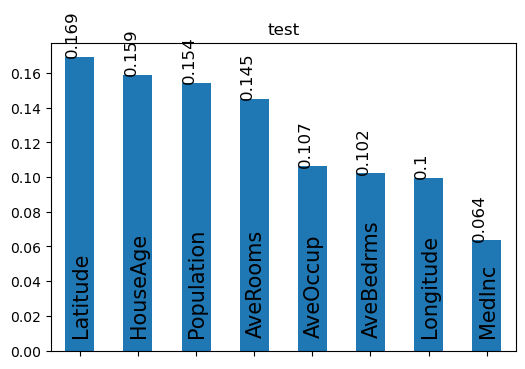

In [12]:
importances = model.predict(datasets["Longitude"], verbose=0)["importances"]

column_list = []
for i, feature in enumerate([col for col in data.columns if col != "target"]):
    column_list.append(feature)
importances = pd.DataFrame(importances[:, :-1], columns=column_list)
average_importances = []
for col_name in [col for col in data.columns if col != "target"]:
    average_importances.append(importances.filter(like=col_name).sum(axis=1))
importances = pd.DataFrame(
    {
        column_name: column_data
        for column_name, column_data in zip([col for col in data.columns if col != "target"], average_importances)
    }
)
imps_sorted = importances.mean().sort_values(ascending=False)
imps_sorted = imps_sorted / sum(imps_sorted)
plt.figure(figsize=(6, 4))
ax = imps_sorted.plot.bar()
for i, p in enumerate(ax.patches):
    ax.annotate(
        str(np.round(p.get_height(), 3)),
        (p.get_x(), p.get_height() * 1.01),
        rotation=90,
        fontsize=12,
    )
    ax.annotate(
        str(imps_sorted.index[i]),
        (p.get_x() + 0.1, 0.01),
        rotation=90,
        fontsize=15,
    )
ax.xaxis.set_tick_params(labelbottom=False)
plt.title("test")
plt.show()

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


inputs = [model.input_dict[key]["Input"][0] for key, value in model.input_dict.items()]
# Define the MLP model

x = layers.concatenate(inputs)  # Concatenate all inputs
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='linear', name='output')(x)


mlp = keras.Model(inputs=inputs, outputs=output)
# Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['mse'])
# Train the model on the TensorFlow dataset
history = mlp.fit(model.training_dataset, validation_data=model.validation_dataset, epochs=100, verbose=1)


Epoch 1/100
8/8 [==============================] - 2s 103ms/step - loss: 0.9607 - mse: 0.9607 - val_loss: 0.8709 - val_mse: 0.8709
Epoch 2/100
8/8 [==============================] - 1s 81ms/step - loss: 0.7856 - mse: 0.7856 - val_loss: 0.6028 - val_mse: 0.6028
Epoch 3/100
8/8 [==============================] - 1s 76ms/step - loss: 0.5656 - mse: 0.5656 - val_loss: 0.4196 - val_mse: 0.4196
Epoch 4/100
8/8 [==============================] - 1s 92ms/step - loss: 0.4712 - mse: 0.4712 - val_loss: 0.3726 - val_mse: 0.3726
Epoch 5/100
8/8 [==============================] - 1s 85ms/step - loss: 0.3973 - mse: 0.3973 - val_loss: 0.3243 - val_mse: 0.3243
Epoch 6/100
8/8 [==============================] - 1s 89ms/step - loss: 0.3589 - mse: 0.3589 - val_loss: 0.3053 - val_mse: 0.3053
Epoch 7/100
8/8 [==============================] - 1s 80ms/step - loss: 0.3344 - mse: 0.3344 - val_loss: 0.2815 - val_mse: 0.2815
Epoch 8/100
8/8 [==============================] - 1s 82ms/step - loss: 0.3192 - mse: 0.3

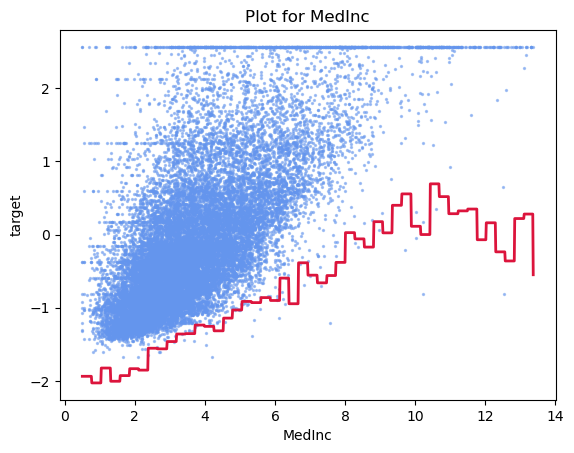

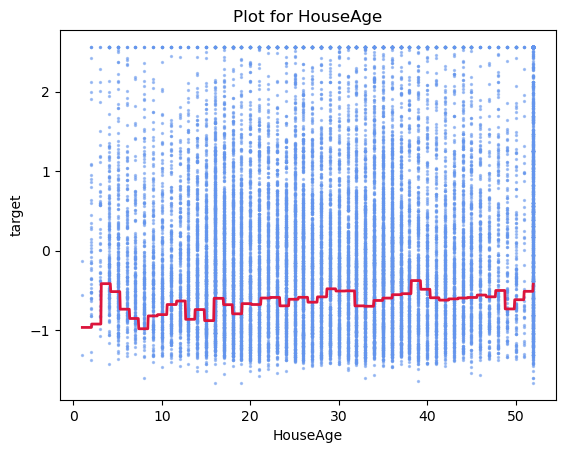

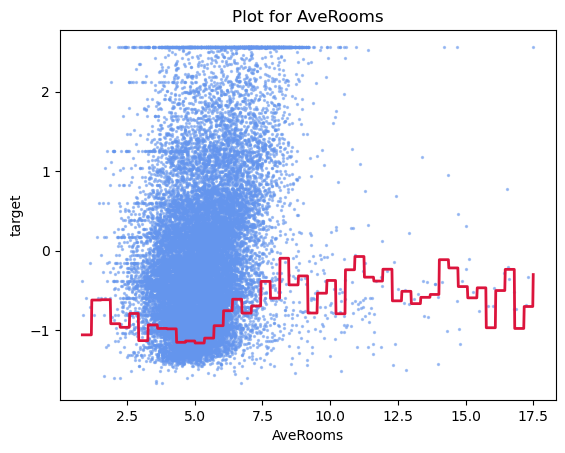

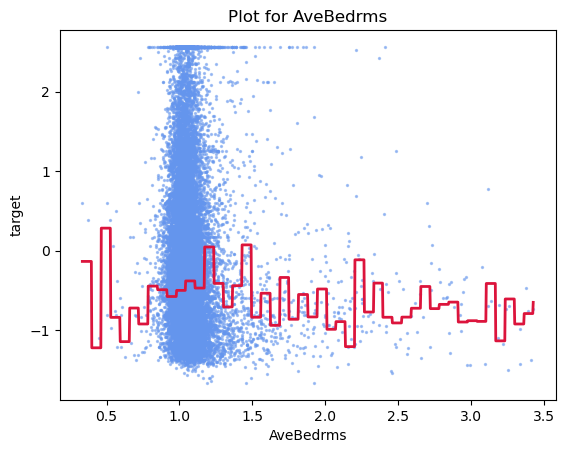

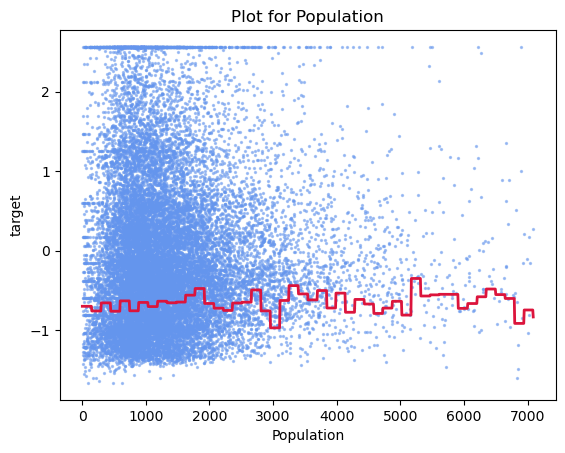

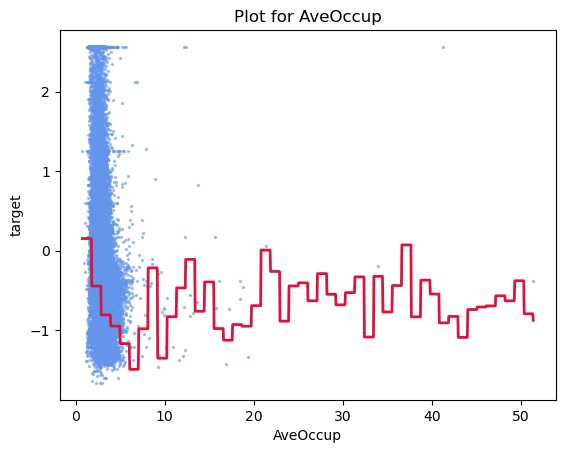

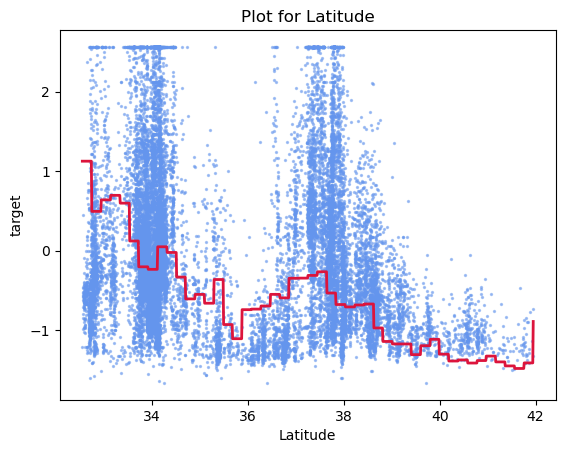

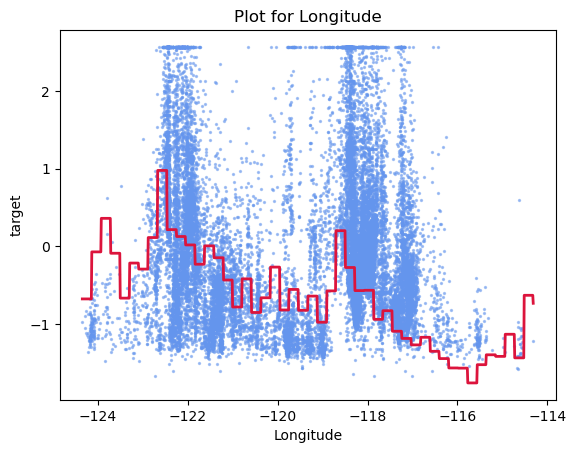

In [14]:
import matplotlib.pyplot as plt

columns_to_plot = [col for col in data.columns if col != "target"]

# Create a separate plot for each column (except target) and overlay predictions
for col in columns_to_plot:
    preds = mlp.predict(datasets[col], verbose=0)
    #preds = preds["output"].squeeze()

    fig, ax = plt.subplots()
    
    ax.scatter(data[col], data["target"], s=2, alpha=0.5, color="cornflowerblue")
    ax.plot(plotting_data[col], preds - np.mean(preds) - 0.65, linewidth=2, color="crimson")
    
    ax.set_title(f"Plot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("target")
    
    plt.show() 

# Simualate some data:

In [15]:


# Set a random seed for reproducibility
np.random.seed(101)

# Number of data points
num_samples = 5000

# Generate the input variable X as a random draw from a linspace
X1 = np.random.uniform(1, 10, size=num_samples)
X2 = np.random.uniform(2, 4, size=num_samples)

# Generate continuous variables as a function of X with noise dependent on X
def func1(x):
    x = 8*np.sin(x**1.5) 
    return x/6

def func2(x):
    x = (2*(x-3))**2
    return x/6


# Calculate y by combining continuous and categorical functions
#
y = func1(X1) - func2(X2)  +  (func1(X1)*func2(X2)) 


data = pd.DataFrame({"target": y, 'Continuous1':X1, 'Continuous2':X2})


In [16]:
model = FTTransformer(
        data=data, 
        y="target",
        output_activation="linear",
        binning_task="regression",
        num_encoding="one_hot_constant",
        n_bins_num=100,
        batch_size=2048,
        dropout=0.5,
        attn_dropout=0.5,
        ff_dropout=0.5,
        embedding_dim=64
        )

--- Preprocessing ---


3it [00:00, 85.50it/s]

In [17]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": "mse", "importances": None, "att_weights": None},
    metrics= {"output": "mse", "importances": None, "att_weights": None},
    )

In [18]:
history = model.fit(
    model.training_dataset, 
    epochs=25, 
    validation_data=model.validation_dataset,
    callbacks=[EARLY_STOPPING],
    verbose=1,
)

Epoch 1/25


2/2 [==============================] - 15s 2s/step - loss: 1.4907 - output_loss: 1.4907 - output_mse: 1.4907 - val_loss: 1.4291 - val_output_loss: 1.4291 - val_output_mse: 1.4291
Epoch 2/25
2/2 [==============================] - 1s 777ms/step - loss: 1.4655 - output_loss: 1.4655 - output_mse: 1.4655 - val_loss: 1.4192 - val_output_loss: 1.4192 - val_output_mse: 1.4192
Epoch 3/25
2/2 [==============================] - 1s 741ms/step - loss: 1.4713 - output_loss: 1.4713 - output_mse: 1.4713 - val_loss: 1.4725 - val_output_loss: 1.4725 - val_output_mse: 1.4725
Epoch 4/25
2/2 [==============================] - 1s 736ms/step - loss: 1.4480 - output_loss: 1.4480 - output_mse: 1.4480 - val_loss: 1.4534 - val_output_loss: 1.4534 - val_output_mse: 1.4534
Epoch 5/25
2/2 [==============================] - 1s 767ms/step - loss: 1.4133 - output_loss: 1.4133 - output_mse: 1.4133 - val_loss: 1.3885 - val_output_loss: 1.3885 - val_output_mse: 1.3885
Epoch 6/25
2/2 [==============================] - 2s 

10it [00:00, 63.48it/s]


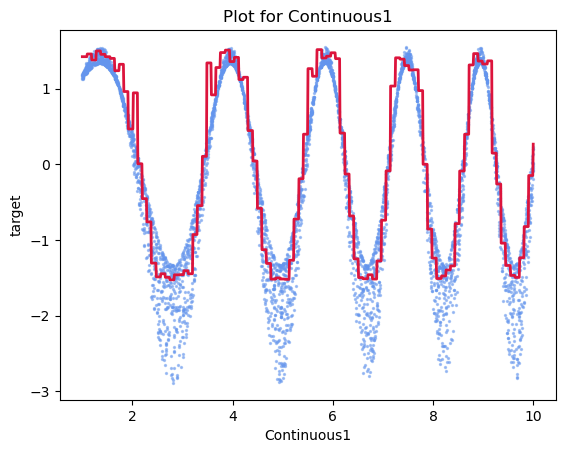

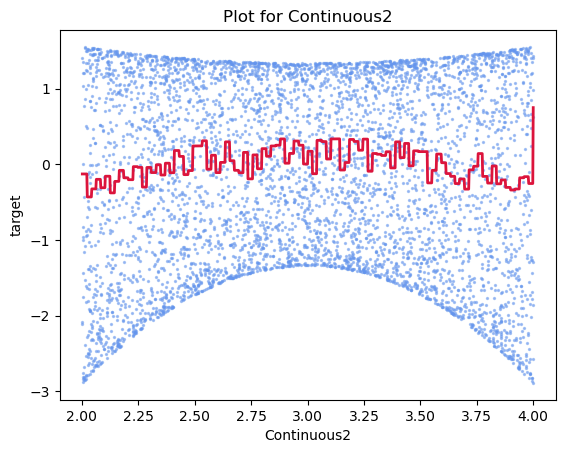

In [19]:
datasets, plotting_data = model.datamodule._generate_plotting_data_ft_transformer()

import matplotlib.pyplot as plt

# Get all columns except the target column
columns_to_plot = [col for col in data.columns if col != "target"]

# Create a separate plot for each column (except target) and overlay predictions
for col in columns_to_plot:
    preds = model.predict(datasets[col], verbose=0)
    preds = preds["output"].squeeze()

    fig, ax = plt.subplots()
    
    ax.scatter(data[col], data["target"], s=2, alpha=0.5, color="cornflowerblue")
    ax.plot(plotting_data[col], preds - np.mean(preds), linewidth=2, color="crimson")
    
    ax.set_title(f"Plot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("target")
    
    plt.show() 

# MLP

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


inputs = [model.input_dict[key]["Input"][0] for key, value in model.input_dict.items()]
# Define the MLP model

x = layers.concatenate(inputs)  # Concatenate all inputs
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='linear', name='output')(x)


mlp = keras.Model(inputs=inputs, outputs=output)
# Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['mse'])
# Train the model on the TensorFlow dataset
history = mlp.fit(model.training_dataset, validation_data=model.validation_dataset, epochs=100, verbose=1)


Epoch 1/100
2/2 [==============================] - 2s 268ms/step - loss: 1.4833 - mse: 1.4833 - val_loss: 1.4612 - val_mse: 1.4612
Epoch 2/100
2/2 [==============================] - 0s 64ms/step - loss: 1.4515 - mse: 1.4515 - val_loss: 1.4472 - val_mse: 1.4472
Epoch 3/100
2/2 [==============================] - 0s 74ms/step - loss: 1.4099 - mse: 1.4099 - val_loss: 1.3739 - val_mse: 1.3739
Epoch 4/100
2/2 [==============================] - 0s 63ms/step - loss: 1.3848 - mse: 1.3848 - val_loss: 1.3864 - val_mse: 1.3864
Epoch 5/100
2/2 [==============================] - 0s 72ms/step - loss: 1.3559 - mse: 1.3559 - val_loss: 1.3093 - val_mse: 1.3093
Epoch 6/100
2/2 [==============================] - 0s 66ms/step - loss: 1.3077 - mse: 1.3077 - val_loss: 1.2445 - val_mse: 1.2445
Epoch 7/100
2/2 [==============================] - 0s 60ms/step - loss: 1.2676 - mse: 1.2676 - val_loss: 1.1222 - val_mse: 1.1222
Epoch 8/100
2/2 [==============================] - 0s 62ms/step - loss: 1.2059 - mse: 1.2

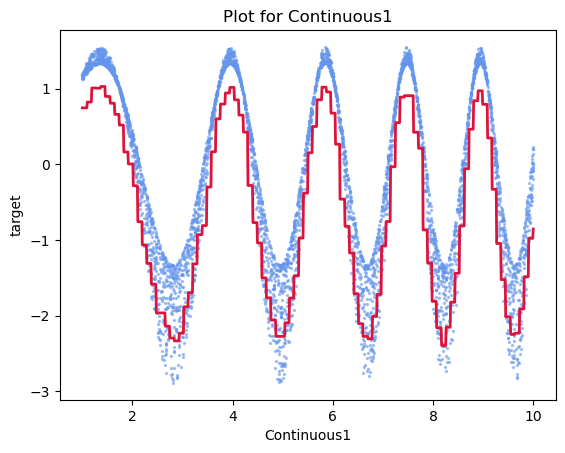

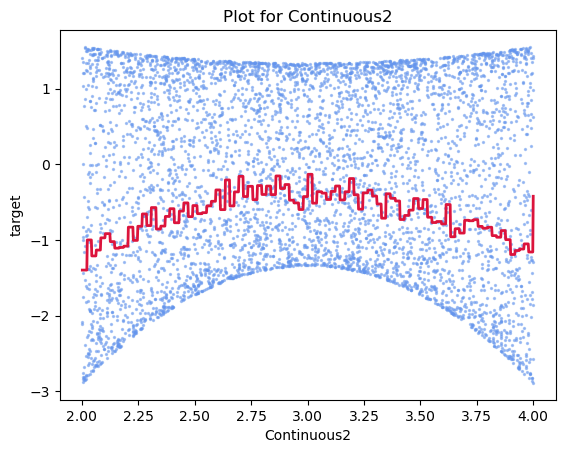

In [21]:
import matplotlib.pyplot as plt

columns_to_plot = [col for col in data.columns if col != "target"]

# Create a separate plot for each column (except target) and overlay predictions
for col in columns_to_plot:
    preds = mlp.predict(datasets[col], verbose=0)
    #preds = preds["output"].squeeze()

    fig, ax = plt.subplots()
    
    ax.scatter(data[col], data["target"], s=2, alpha=0.5, color="cornflowerblue")
    ax.plot(plotting_data[col], preds - np.mean(preds) - 0.65, linewidth=2, color="crimson")
    
    ax.set_title(f"Plot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("target")
    
    plt.show() 

# with unpreprocessed inputs

In [23]:
data.head()

target  Continuous1  Continuous2
0  1.007009     5.647588     2.506362
1  0.508340     6.136008     2.224183
2  1.371395     1.256268     2.485680
3 -2.392434     2.543695     2.013191
4  0.116985     7.167493     3.938979

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Extracting features and target
features = data[['Continuous1', 'Continuous2']].values
target = data['target'].values

# Define the model
model = Sequential([
    layers.Normalization(input_shape=(2,)),
    Dense(512, activation='relu'),
    layers.Dropout(0.1),    # Two input variables
    Dense(128, activation='relu'),
    layers.Dropout(0.1),    # Two input variables
    Dense(32, activation='relu'),
    Dense(1)  # One output neuron for regression (change for classification)
])

# Compile the model (specify loss and optimizer)
model.compile(optimizer='adam', loss='mean_squared_error')  # For regression
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # For classification

# Train the model
model.fit(features, target, epochs=500, batch_size=512)


Epoch 1/500
10/10 [==============================] - 1s 10ms/step - loss: 1.4231
Epoch 2/500
10/10 [==============================] - 0s 10ms/step - loss: 1.3656
Epoch 3/500
10/10 [==============================] - 0s 9ms/step - loss: 1.3229
Epoch 4/500
10/10 [==============================] - 0s 10ms/step - loss: 1.2973
Epoch 5/500
10/10 [==============================] - 0s 8ms/step - loss: 1.2827
Epoch 6/500
10/10 [==============================] - 0s 10ms/step - loss: 1.2724
Epoch 7/500
10/10 [==============================] - 0s 12ms/step - loss: 1.2610
Epoch 8/500
10/10 [==============================] - 0s 12ms/step - loss: 1.2575
Epoch 9/500
10/10 [==============================] - 0s 11ms/step - loss: 1.2440
Epoch 10/500
10/10 [==============================] - 0s 10ms/step - loss: 1.2332
Epoch 11/500
10/10 [==============================] - 0s 10ms/step - loss: 1.2171
Epoch 12/500
10/10 [==============================] - 0s 10ms/step - loss: 1.2013
Epoch 13/500
10/10 [=======

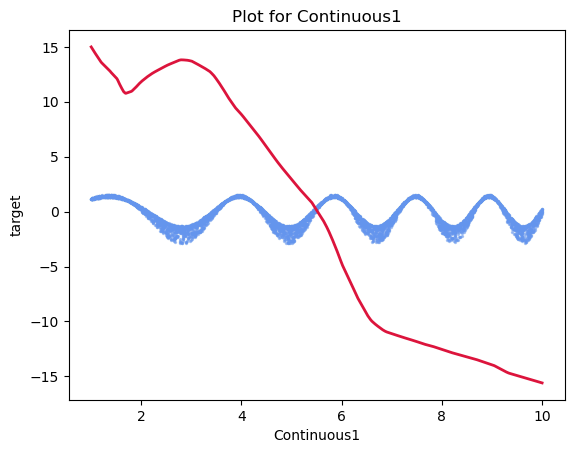

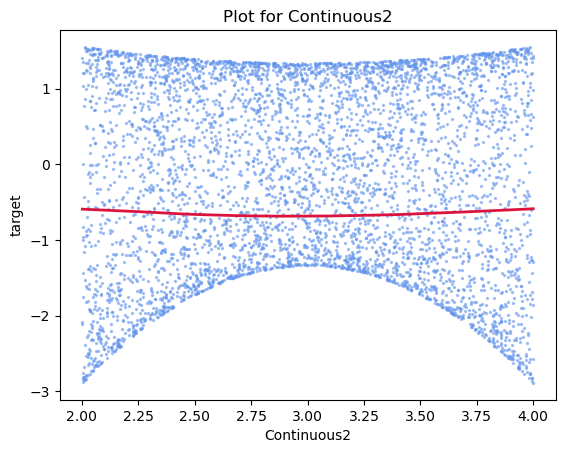

In [44]:
import copy


for col in ["Continuous1", "Continuous2"]:
    df = pd.DataFrame(columns=["Continuous1", "Continuous2"])
    other_col = "Continuous1" if col == "Continuous2" else "Continuous2"
    df[col] = np.linspace(np.min(data[col]), np.max(data[col]), 1000)
    
    df[other_col] = np.repeat(-1, 1000)

    features = df.values
    preds = model.predict(features, verbose=0)
    #preds = preds["output"].squeeze()

    fig, ax = plt.subplots()
    
    ax.scatter(data[col], data["target"], s=2, alpha=0.5, color="cornflowerblue")
    ax.plot(plotting_data[col], preds - np.mean(preds) - 0.65, linewidth=2, color="crimson")
    
    ax.set_title(f"Plot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("target")
    
    plt.show() 